# Início da codificação

In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
# from sklearn import linear_model, preprocessing, metrics, model_selection
from sklearn import metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import seaborn as sn

SEED = 10

np.random.seed(SEED)

# Configuração do preditor de arremessos

In [2]:
registered_model_name = 'modelo_arremesso' # Define o nome do modelo
min_precision = 0.5 # Define a precisão
model_version = -1 # Inicializa o controle de versão como -1 para que Client Mlflow verifique se existe alguma versão publicada
nexamples = 5

# Experimento de classificação de arremessos

In [7]:
# O componente MLflow Tracking é uma API e interface do usuário para registrar parâmetros, versões de código, métricas e arquivos de saída 
# ao executar seu código de aprendizado de máquina e para visualizar os resultados posteriormente.
# Muitos usuários também executam o MLflow em suas máquinas locais com um banco de dados compatível com SQLAlchemy : SQLite . 
# Nesse caso, os artefatos são armazenados no ./mlruns diretório local e as entidades MLflow são inseridas em um arquivo de banco de dados SQLite mlruns.db.

# Configura o MLflow para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Classificador de Arremessos' # Define o nome do experimento
experiment = mlflow.get_experiment_by_name(experiment_name) # Recupera um experimento na loja de back-end a partir do seu nome.
if experiment is None: # Se o experimento não foi encontrado
    experiment_id = mlflow.create_experiment(experiment_name) # Cria um experimento na loja de back-end usando o nome indicado e recupera o seu id
    experiment = mlflow.get_experiment(experiment_id) # Recupera o experimento criado o passo anterior na loja de back-end a partir do seu id.
experiment_id = experiment.experiment_id # recuperar id do experimento a partir do objeto experimento

# Leitura dos dados de arremessos 

In [9]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

top_features = ['lat','lon','minutes_remaining', 'playoffs','shot_distance'] # Define a features principais
percentual_teste=0.2

# Inicia uma nova execução do MLflow, definindo-a como a execução ativa na qual as métricas e os parâmetros serão registrados. 
# O valor de retorno pode ser usado como gerenciador de contexto dentro de um withbloco; 
# caso contrário, você deve chamar end_run() para encerrar a execução atual.

with mlflow.start_run(experiment_id = experiment_id, run_name = 'PreparacaoDados'):
    
    # Carrega os dados no dataframe
    df_original = pd.read_csv('../Data/dataset_kobe.csv',sep=',') 
    # Define a coluna alvo
    target_col = 'shot_made_flag'
    # Copia todos os dados do dataframe original selecionando apenas as features principais (top_features) e o alvo (shot_type)
    df = df_original[top_features + ['shot_type', target_col]].copy()
    # remove a linha que possua alguma coluna vazia
    df = df.dropna() 
    # converte a coluna shot_made_flag em inteiro 
    df['shot_made_flag'] = df['shot_made_flag'].astype(int)  
    # Copia os dados do dataframe que possui as top_features selecionando apenas os casos onde shot_type for igual a "2PT Field Goal"
    # e remove a coluna shot_type para compor a base de treino, teste e operação
    df_filtered = df[df['shot_type'] == '2PT Field Goal'].copy().drop('shot_type', axis=1)
    
    # Separar 80% do dataframe que contém shot_type for igual a "2PT Field Goal"para compor a base de treinamento/teste e 20% para a base de operação
    df_train, df_test, y_train, y_test = model_selection.train_test_split(
        df_filtered, 
        df_filtered[target_col],
        test_size=percentual_teste,
        random_state=None,
        shuffle=True,
        stratify=None)
    
    # 80% dados para treino e teste
    df_train[target_col] = y_train
    # 20% dados para operação
    df_test[target_col] = y_test
    
    # Copia os dados do dataframe que possui as top_features selecionando apenas os casos onde shot_type for igual a "3PT Field Goal"
    # e remove a coluna shot_type para compor a base de novidades
    df_novelty = df[df['shot_type'] == '3PT Field Goal'].copy().drop('shot_type', axis=1)
    
    # grava os dataframes em arquivos parquet.
    df_filtered.to_parquet('../Data/processed/data_filtered.parquet') 
    df_train.to_parquet('../Data/operalization/base_train.parquet') 
    df_test.to_parquet('../Data/operalization/base_test.parquet')
    df_novelty.to_parquet('../Data/operalization/base_novelty.parquet')
    
    # to_parquet - Esta função grava o dataframe como um arquivo parquet.
    # O Apache Parquet fornece uma serialização colunar binária particionada para quadros de dados. 
    # Ele foi projetado para tornar a leitura e gravação de quadros de dados eficientes e para facilitar o compartilhamento de dados entre linguagens de análise de dados. 
    # O Parquet pode usar uma variedade de técnicas de compactação para reduzir o tamanho do arquivo o máximo possível, mantendo um bom desempenho de leitura.
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("top_features", top_features)
    mlflow.log_param("% Teste", top_features)

    # LOG DE METRICAS GLOBAIS
    # logs a single key-value metric. The value must always be a number. MLflow remembers the history of values for each metric. 
    # Use mlflow.log_metrics() to log multiple metrics at once.
    mlflow.log_metric("Dados filtrados", df_filtered.shape[0])
    mlflow.log_metric("Dados de treino", df_train.shape[0])
    mlflow.log_metric("Dados de teste", df_test.shape[0])
    mlflow.log_metric("Dados novos", df_novelty.shape[0])
    
    # LOG DE ARTEFATOS
    # mlflow.log_artifact() logs a local file or directory as an artifact, optionally taking an artifact_path to place it in within the run’s artifact URI. 
    # Run artifacts can be organized into directories, so you can place the artifact in a directory this way.
    mlflow.log_artifact('../Data/processed/data_filtered.parquet')
    mlflow.log_artifact('../Data/operalization/base_train.parquet')
    mlflow.log_artifact('../Data/operalization/base_test.parquet')
    mlflow.log_artifact('../Data/operalization/base_novelty.parquet')

mlflow.end_run()

print('== Bases de Dados ======================================')
print(f'Dados filtrados: {df_filtered.shape}')
print(f'Dados de treino: {df_train.shape}')
print(f'Dados de teste: {df_test.shape}')
print(f'Dados novos: {df_novelty.shape}')
print(f'Columns: {df_train.columns}')

== Bases de Dados ======================================
Dados filtrados: (20285, 6)
Dados de treino: (16228, 6)
Dados de teste: (4057, 6)
Dados novos: (5412, 6)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'playoffs', 'shot_distance',
       'shot_made_flag'],
      dtype='object')


C:\Users\spereira\AppData\Local\Temp\ipykernel_22120\517986200.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target_col] = y_train
C:\Users\spereira\AppData\Local\Temp\ipykernel_22120\517986200.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target_col] = y_test


In [5]:
# mlflow ui --backend-store-uri sqlite:///mlruns.db -p 5002

# Treinamento do modelo

In [10]:
import pycaret.classification as pc # Essa função inicializa o ambiente de treinamento e cria o pipeline de transformação.
# COLOCAR RUN DE TREINAMENTO DE MODELOS
# PARAMETROS: fold_strategy, fold, model_name, registered_model_name, cross_validation
# METRICS: auto sklearn
# ARTIFACTS: plots

model_name_list = ['lr', 'dt']
probability_threshold = 0.5
cross_validation = True
fold_strategy = 'stratifiedkfold'
fold = 10

# train/test
s = pc.setup(data = df_train, # Dados para treino e teste dos modelos
             test_data = df_test,
             numeric_features = top_features,
             target = target_col,
             #train_size=0.8,
             silent = True,
             #fold_strategy = fold_strategy,
             #fold = fold,
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True,
             normalize = True  # Normalização, transformação e remoção de variáveis
            )

# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
pc.add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

# O PyCaret treina os modelos com hiperparametros defaults, sem ajuste fino.
#bestmodel = pc.compare_models(n_select = 1, sort='Accuracy', include=model_name_list, probability_threshold = probability_threshold, cross_validation = cross_validation)
bestmodel = pc.compare_models(n_select = 1, sort='logloss', include=model_name_list, probability_threshold = probability_threshold, cross_validation = cross_validation)
# compare_models - This function trains and evaluates the performance of all estimators available in the model library using cross-validation. 
# The output of this function is a scoring grid with average cross-validated scores. 
# Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

# bestmodel = pc.create_model(model_name, cross_validation = cross_validation, probability_threshold = probability_threshold)

# Log do run, e nao do modelo respectivo
classification_plots = [ 'auc','pr','confusion_matrix',
                        'threshold', 'learning','vc','feature']
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(bestmodel, plot=plot_type, save=True, use_train_data=False)
        mlflow.log_artifact(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue

pc.save_model(bestmodel, f'./{registered_model_name}') 
# Carrega novamente o pipeline + bestmodel
model_pipe = pc.load_model(f'./{registered_model_name}')

mlflow.end_run()

print(pc.pull());

INFO  [logs] Saving 'Feature Importance.png'
INFO  [logs] Visual Rendered Successfully
INFO  [logs] plot_model() succesfully completed......................................
INFO  [logs] Initializing save_model()
INFO  [logs] save_model(model=CustomProbabilityThresholdClassifier(C=1.0, class_weight=None,
                                     classifier=LogisticRegression(C=1.0,
                                                                   class_weight=None,
                                                                   dual=False,
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=1000,
                                                                   multi_class='auto',
                              

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
                       Model  Accuracy     AUC  Recall   Prec.      F1  \
lr       Logistic Regression    0.5781  0.5994  0.4972  0.5690  0.5307   
dt  Decision Tree Classifier    0.5426  0.5192  0.6148  0.5198  0.5632   

     Kappa     MCC  LogLoss  TT (Sec)  
lr  0.1507  0.1519  14.5708     1.340  
dt  0.0903  0.0917  15.7968     0.017  


# Avaliar a precisão mínima do modelo

In [11]:
# COLOCAR RUN APROVACAO DE MODELO
# PARAMETROS: min_precision
# METRICS: new_version, precision
# ARTIFACTS: None



with mlflow.start_run(experiment_id = experiment_id, run_name = 'AprovacaoModelo'):
    
    pred_holdout = pc.predict_model(bestmodel)
    pr = metrics.precision_score(pred_holdout[target_col], pred_holdout['Label'],) # Calcula a precisão
    # A precisão é a razão tp / (tp + fp) onde tp é o número de verdadeiros positivos e fp o número de falsos positivos. 
    # A precisão é intuitivamente a capacidade do classificador não rotular como positiva uma amostra que é negativa.
    # O melhor valor é 1 e o pior valor é 0.
    if pr > min_precision: # se o modelo atingiu a precisão mínima configurada
        print(f'=> Aceito o modelo com precisão {pr} (min: {min_precision})')
        pred_holdout.to_parquet('modelo_arremesso_teste.parquet') # Salva o modelo
        # Assinatura do Modelo Inferida pelo MLFlow
        model_features = list(df_filtered.drop(target_col, axis=1).columns) # armazena as features do modelo
        inf_signature = infer_signature(df_filtered[model_features], model_pipe.predict(df_filtered))
        # Exemplo de entrada para o MLmodel
        input_example = {x: df_filtered[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example
        )
        
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        client = MlflowClient()
        if model_version == -1:
            model_version = client.get_latest_versions(registered_model_name)[-1].version
            
        # Registrar o modelo como staging
        client.transition_model_version_stage(
            name=registered_model_name,
            version=model_version, 
            stage="Staging"
        )
    else:
        print(f'=> Rejeitado o modelo com precisão {pr} (min: {min_precision})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_precision)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("precisao", pr)

mlflow.end_run()

INFO  [logs] Initializing predict_model()
INFO  [logs] predict_model(estimator=CustomProbabilityThresholdClassifier(C=1.0, class_weight=None,
                                     classifier=LogisticRegression(C=1.0,
                                                                   class_weight=None,
                                                                   dual=False,
                                                                   fit_intercept=True,
                                                                   intercept_scaling=1,
                                                                   l1_ratio=None,
                                                                   max_iter=1000,
                                                                   multi_class='auto',
                                                                   n_jobs=None,
                                                                   penalty='l2',
                                

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Logistic Regression,0.5716,0.5900,0.4705,0.5492,0.5068,0.1321,0.1334,14.7964


=> Aceito o modelo com precisão 0.54920049200492 (min: 0.5)


Successfully registered model 'modelo_arremesso'.
2022/09/14 23:17:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_arremesso, version 1
Created version '1' of model 'modelo_arremesso'.


# Serviço do Modelo 

In [12]:
# Para implantar um modelo associado a uma execução em um servidor de rastreamento, 
# defina a variável de ambiente MLFLOW_TRACKING_URI para a URL do servidor desejado.
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db' # Criando uma variável de ambiente

In [13]:
# Para implantar o servidor, execute
!mlflow models serve -m "models:/modelo_arremesso/Staging" --no-conda -p 5001

# Depois deste comando é necessário interromper o kernel

^C


In [ ]:
## Comando Power Shell para criar variável de ambiente e implantar o modelo
# $env:MLFLOW_TRACKING_URI = 'sqlite:///mlruns.db'

# Comando Powershell para listar variáveis de ambiente
# dir env:

# Comando para publicar o modelo
# mlflow models serve -m "models:/modelo_arremesso/Staging" --no-conda -p 5001

# Operação do sistema preditor de arremessos

In [14]:
import requests
# Configura a requisição
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

# Serializa os dados do dataframe operação removendo a coluna alvo para usar na requisição
http_data = df_novelty.drop(target_col,axis=1).to_json(orient='split') 

# Executa a requisição
r = requests.post(url=url, headers=headers, data=http_data)

# Recupera o resultado da requisição e armazena no dataframe operação
df_novelty.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0] 

# Salva o dataframe operação
df_novelty.to_parquet('../Data/operalization/base_novelty.parquet')

# Lista os casos onde o resultado do modelo seja 1 e ordenado pela distância da maior para a menor.
df_novelty[df_novelty.operation_label == 1].sort_values('shot_distance', ascending=False).head(5)

,lat,lon,minutes_remaining,playoffs,shot_distance,shot_made_flag,operation_label
22904,34.0443,-118.2698,6,0,0,0,1


# Revalidacao de Amostras para Monitoramento

In [15]:
# COLOCAR RUN REVALIDACAO
# PARAMETROS: min_samples_control
# METRICS: matriz de confusao
# ARTIFACTS:

# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 150

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    # Recupera os dados de operação e armazena no dataframe
    df_novelty = pd.read_parquet('../Data/operalization/base_novelty.parquet')

    # Extrai do dataframe de operação algumas amostras para controle
    data_control = df_novelty.sample(min_samples_control, random_state=SEED)
    
    # Salva as amostras de controle em um arquivo
    data_control.to_parquet('modelo_arremesso_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    # classification_report - Cria um relatório de texto mostrando as principais métricas de classificação.
    print(metrics.classification_report(data_control[target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[target_col], data_control['operation_label'])
    # ESPECIFICIDADE - A proporção de verdadeiros negativos: a capacidade do sistema em predizer corretamente a ausência da condição para casos que realmente não a têm.
    # ESPECIFICIDADE = ACERTOS NEGATIVOS / TOTAL DE NEGATIVOS
    specificity = cm[0,0] / cm.sum(axis=1)[0] # VN / (VN + FP)
    # SENSIBILIDADE - A proporção de verdadeiros positivos: a capacidade do sistema em predizer corretamente a condição para casos que realmente a têm.
    # SENSIBILIDADE = ACERTOS POSITIVOS / TOTAL DE POSITIVOS
    sensibility = cm[1,1] / cm.sum(axis=1)[1] # VP / (VP + FN)
    # PRECISON - A precisão é uma métrica que avalia a quantidade de verdadeiros positivos sobre a soma de todos os valores positivos
    precision   = cm[1,1] / cm.sum(axis=0)[1] # VP / (FP + VP)
    
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        92
           1       0.00      0.00      0.00        58

    accuracy                           0.61       150
   macro avg       0.31      0.50      0.38       150
weighted avg       0.38      0.61      0.47       150



## Alarme de Desvio 

In [16]:
def data_drift_alarm(var_name, dev_data, data_test, data_control):    
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Densidade')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

## Alarme de Retreinamento

In [17]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0] # VN / (VN + FP)
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1] # VP / (FN + VP)
    precision_m   = cm[1,1] / cm.sum(axis=0)[1] # VP / (FP + VP)

    cm = metrics.confusion_matrix(testset[target_col], testset['Label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0] # VN / (VN + FP)
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1] # VP / (FN + VP)
    precision_t   = cm[1,1] / cm.sum(axis=0)[1] # VP / (FP + VP)

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

# Operação Aplicação Python

### Monitoramento Base de Novidade

== ALARME DE RETREINAMENTO - BASE NOVIDADE ==
	=> especificidade de teste 0.6604909680407596 e de controle 0.9997245179063361
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.47049525816649107 e de controle 0.0
	=> MODELO OPERANDO FORA DO ESPERADO
	=> precisao de teste 0.54920049200492 e de controle 0.0
	=> MODELO OPERANDO FORA DO ESPERADO
==> RETREINAMENTO NECESSARIO


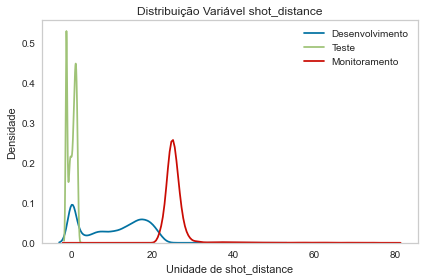

In [20]:
# COLOCAR RUN MONITORAMENTO NOVIDADE
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_arremesso/Staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('../Data/operalization/base_novelty.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty.drop(target_col,axis=1))
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'shot_distance'
    data_drift_alarm(var_name, df_filtered, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run() 